In [ ]:
#| default_exp lp_diffusion
from diffusion_curvature.gaussian_invariance import compute_anisotropic_diffusion_matrix_from_graph
from diffusion_curvature.core import gaussian_kernel, plot_3d, diffusion_matrix
from nbdev.showdoc import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import diffusion_curvature
# Reload any changes made to external files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


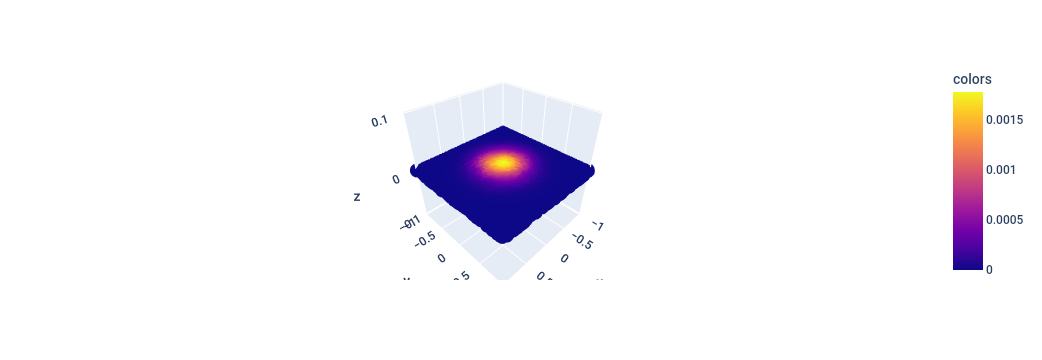

In [ ]:
coords_2d = np.random.rand(5000,2)*2-1
coords_2d = np.vstack([np.zeros(2),np.array([0,0.2]),np.array([0,-0.2]),np.zeros(2),coords_2d])
A = gaussian_kernel(coords_2d, kernel_type="adaptive",k=10)
P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
t = 8
P_t = np.linalg.matrix_power(P,t)
y = P_t[0]
# plot, now in 3d
def plot_diffusion_as_3d(points,signal):
    combined_points = np.hstack([points,signal[:,None]])
    plot_3d(combined_points,signal,lim=1,zlim=max(signal)+0.1, use_plotly=True)
plot_diffusion_as_3d(coords_2d,y)

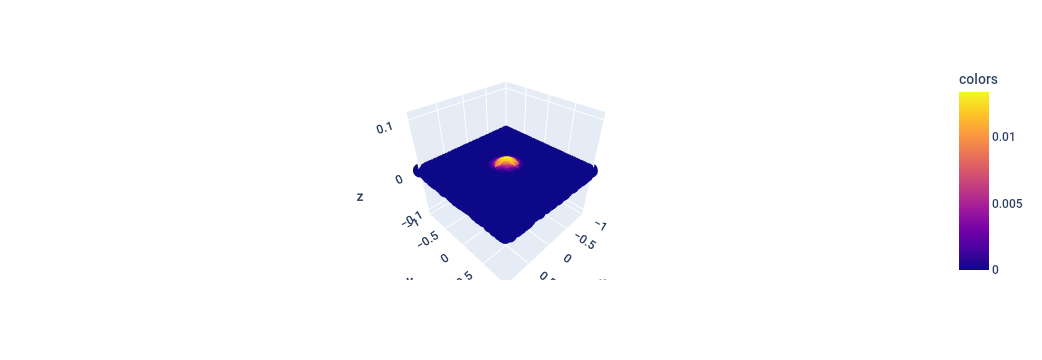

In [ ]:
y_reversed = y**(t)
y_reversed = y_reversed/np.sum(y_reversed) # normalize
plot_diffusion_as_3d(coords_2d,y_reversed)

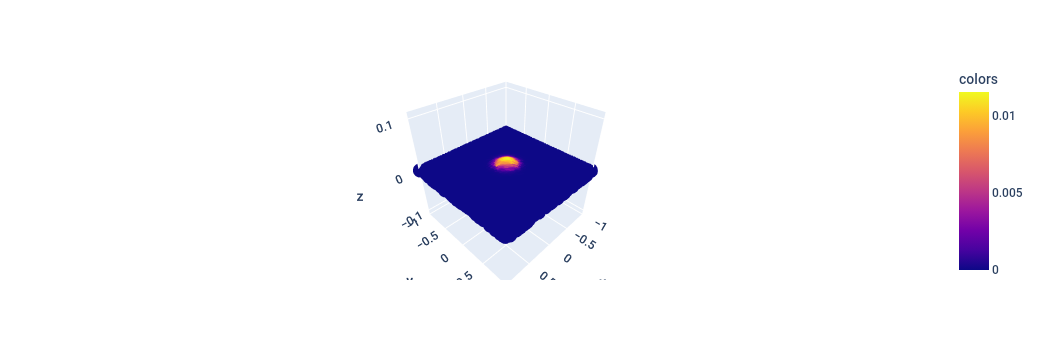

In [ ]:
plot_diffusion_as_3d(coords_2d,P[0])

In [ ]:
np.linalg.norm(y_reversed - P[0])

0.06679578587311553

In [ ]:
np.linalg.norm(y_reversed - P[0])

0.06679578587311553

In [ ]:
def fit_kernel_bandwidth_adaptive(query_distribution, pointcloud, center_idx):
    # finds the kernel bandwidth that best fits the query distribution
    # currently brute forcing by testing a bunch of possible ks
    ks = list(range(2,20))
    fits = []
    for k in ks:
        P = gaussian_kernel(pointcloud,kernel_type="adaptive",k=k)
        candidate_signal = P[center_idx]
        fits.append(np.linalg.norm(candidate_signal - query_distribution))
    return np.argmin(fits)+2
def fit_kernel_bandwidth_fixed(query_distribution, pointcloud, center_idx):
    # finds the kernel bandwidth that best fits the query distribution
    # currently brute forcing by testing a bunch of possible ks
    sigmas = np.arange(0.02,0.3,0.01)
    fits = []
    for s in sigmas:
        P = gaussian_kernel(pointcloud,kernel_type="fixed",sigma=s)
        candidate_signal = P[center_idx]
        fits.append(np.linalg.norm(candidate_signal - query_distribution))
    return np.argmin(fits)+2

In [ ]:
fit_kernel_bandwidth_adaptive(y_reversed,coords_2d,0)

  0%|          | 0/18 [00:00<?, ?it/s]

[0.3713033729970745, 0.24778568164538367, 0.2004988126890528, 0.1789376462010251, 0.16045377024332916, 0.14524970111620877, 0.08821152818871371, 0.0766124777725365, 0.06520241051864308, 0.062145391807865324, 0.0609929921272294, 0.06049125413426953, 0.0610957466451291, 0.0639108936207101, 0.06502840134564573, 0.06557413509723353, 0.06757775319899405, 0.06916545359669424]


13

# Applying to the Sphere

In [ ]:
from diffusion_curvature.datasets import sphere
X, ks_real = sphere(2000)
A = gaussian_kernel(X, kernel_type="adaptive",k=10)
P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
t = 8
P_t = np.linalg.matrix_power(P,t)
y = P_t[0]
y_reversed = y**(t)

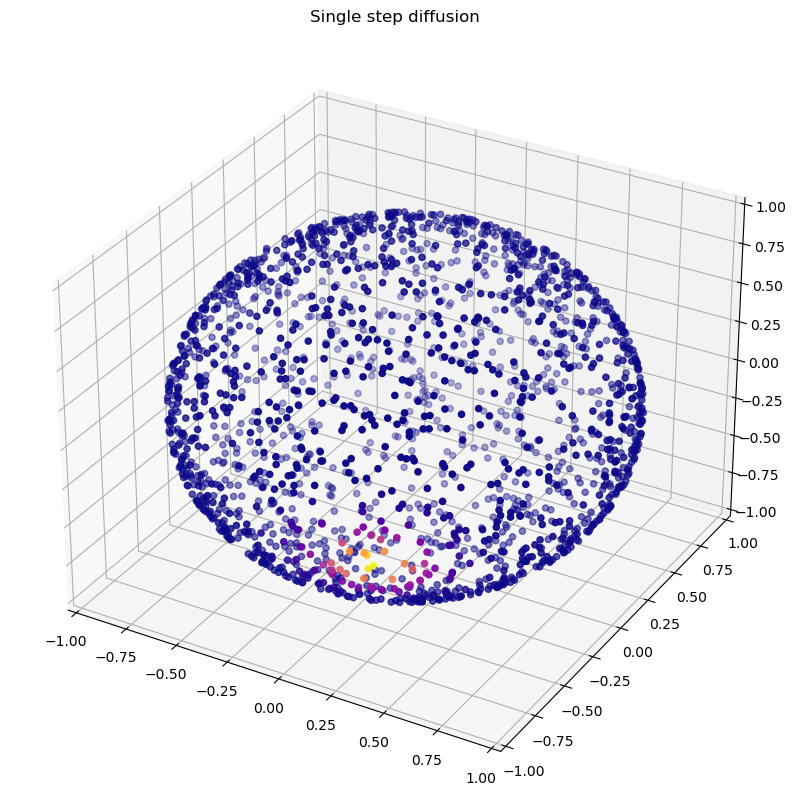

In [ ]:
plot_3d(X,P[0],title="Single step diffusion")

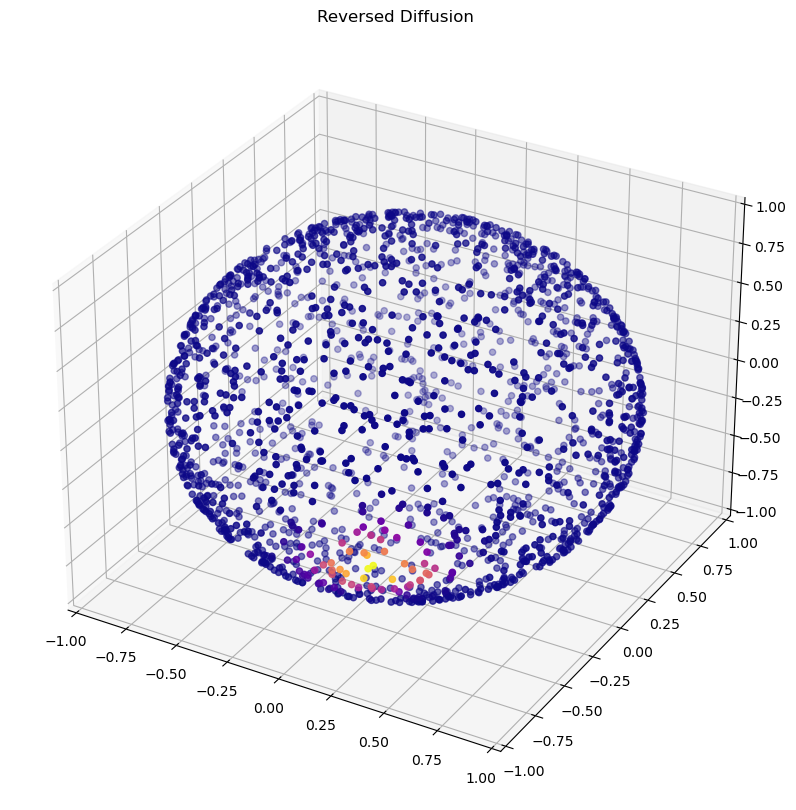

In [ ]:
plot_3d(X,distribution=y_reversed,title="Reversed Diffusion")

In [ ]:
fit_kernel_bandwidth_adaptive(y_reversed,X,0)

  0%|          | 0/18 [00:00<?, ?it/s]

[0.3120194833450645, 0.25473248858824676, 0.21062658992998212, 0.19670869939038435, 0.18520905055293263, 0.17482037304841402, 0.16590842981209156, 0.15327495869442, 0.14762728635093395, 0.14334805490053798, 0.13621509851319547, 0.12991786850963039, 0.1257766971486057, 0.12351220775879587, 0.11970313544349731, 0.11541030053987149, 0.11296987695388477, 0.110965978633877]


19

# Tying it all together into a method

In [ ]:
def reverse_diffusion_curvature(X,t=8, k = 10):
    A = gaussian_kernel(X, kernel_type="adaptive",k=k)
    P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
    # get powered diffusions
    Pt = np.linalg.matrix_power(P,t)
    # calculate reversed diffusions and normalize
    P_reversed = Pt**t
    P_reversed = P_reversed / np.sum(P_reversed,axis=1)[:,None]
    # laboriously fit kernel bandwidth to each curvature
    ks = np.empty(len(X))
    for i in trange(len(X)):
        ks[i] = k - fit_kernel_bandwidth_adaptive(P_reversed[i],X,i)
    return ks

In [ ]:
from diffusion_curvature.datasets import torus
X,ks_real = torus(2000)

In [ ]:
ks = reverse_diffusion_curvature(X,t=8)

  0%|          | 0/993 [00:00<?, ?it/s]

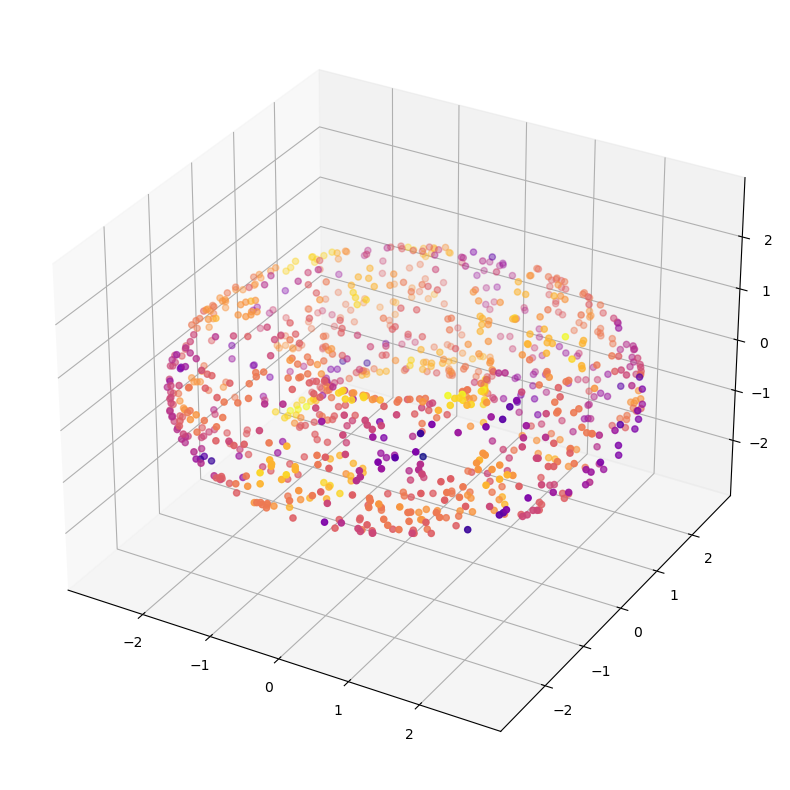

In [ ]:
plot_3d(X,ks)

In [ ]:
A = gaussian_kernel(X, kernel_type="adaptive",k=10)
P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
ks_denoised = P@ks

In [ ]:
min(ks)

-9.0

In [ ]:
max(ks)

3.0

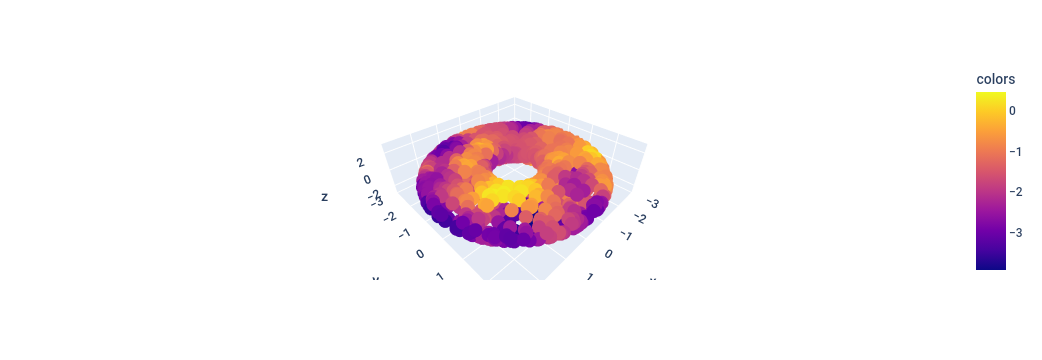

In [ ]:
plot_3d(X,ks_denoised, use_plotly=True)

In [ ]:
import scipy.stats
def reverse_diffusion_curvature_l2_concentration(X,t=8, k = 10):
    A = gaussian_kernel(X, kernel_type="adaptive",k=k)
    P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
    # get powered diffusions
    Pt = np.linalg.matrix_power(P,t)
    # calculate reversed diffusions
    P_reversed = Pt**t
    P_reversed = P_reversed / np.sum(P_reversed,axis=1)[:,None]
    # take entropy of both as measure of concentration
    P_entropy = np.array([scipy.stats.entropy(x) for x in P])
    P_reversed_entropy = np.array([scipy.stats.entropy(x) for x in P_reversed])
    # take differences; we expect positive curvature to have a higher concentration -> higher l2 norm
    ks = P_reversed_entropy #- P_entropy
    return ks

In [ ]:
from diffusion_curvature.datasets import torus
X,ks_real = torus(5000)

In [ ]:
ks = reverse_diffusion_curvature_l2_concentration(X,t=16, k = 20)

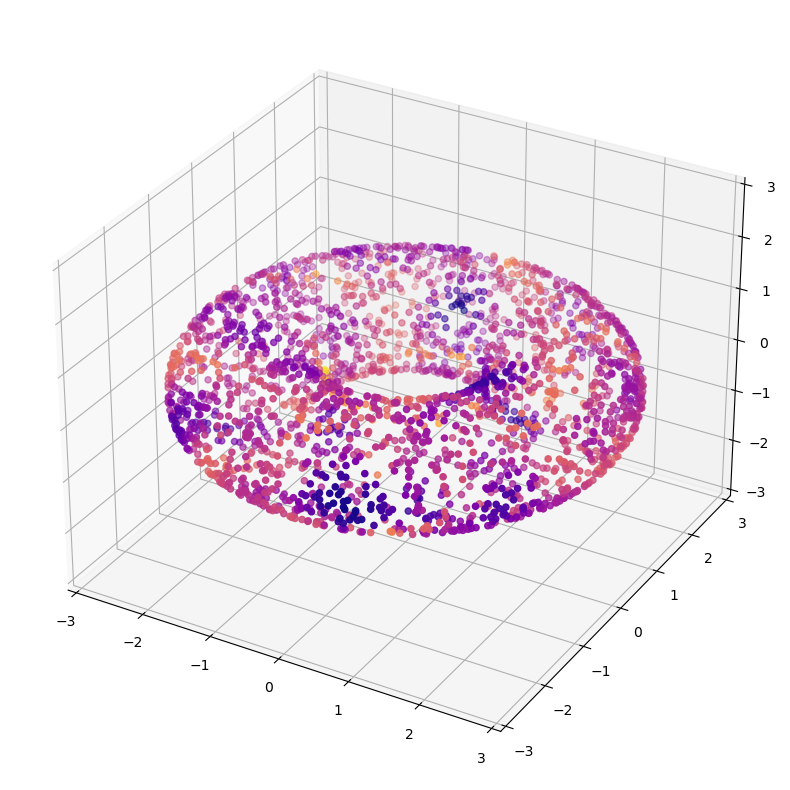

In [ ]:
plot_3d(X,ks)

In [ ]:
def entropy_of_diffusion(X,t=8,k=10):
    A = gaussian_kernel(X, kernel_type="adaptive",k=k)
    P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
    # get powered diffusions
    Pt = np.linalg.matrix_power(P,t)
    P_entropy = np.array([scipy.stats.entropy(x) for x in Pt])
    return P_entropy

In [ ]:
ks = entropy_diffusion(X)

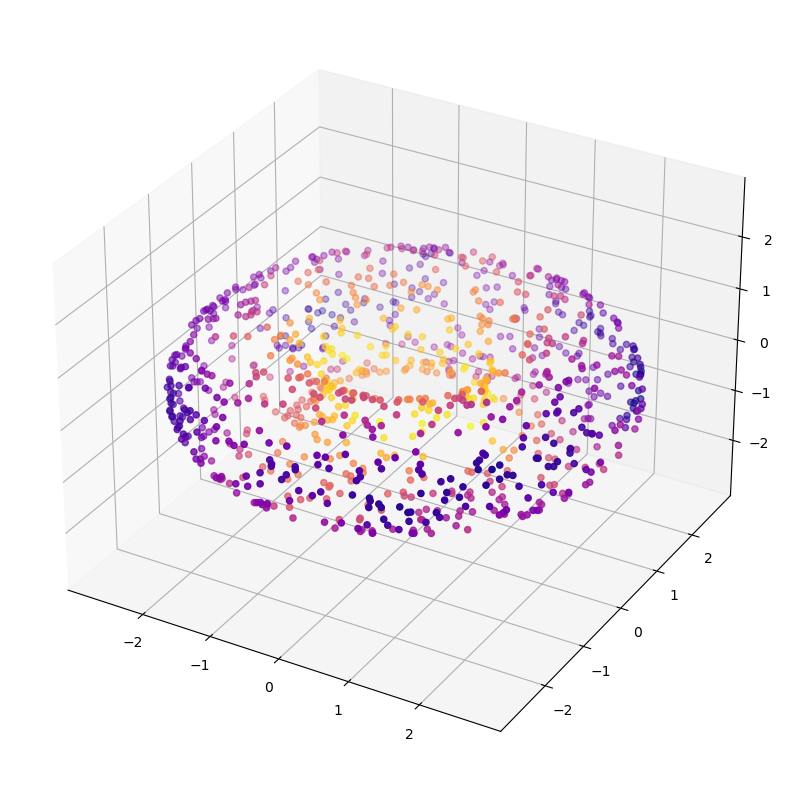

In [ ]:
plot_3d(X,ks)

# Entropy Ablations

In [ ]:
A = gaussian_kernel(X, kernel_type="adaptive",k=10)
P = compute_anisotropic_diffusion_matrix_from_graph(A, alpha=1)
# get powered diffusions
Pt = np.linalg.matrix_power(P,8)
P_entropy = np.array([scipy.stats.entropy(x) for x in Pt])

In [ ]:
P_local_entropy = np.array([scipy.stats.entropy(x) for x in P])

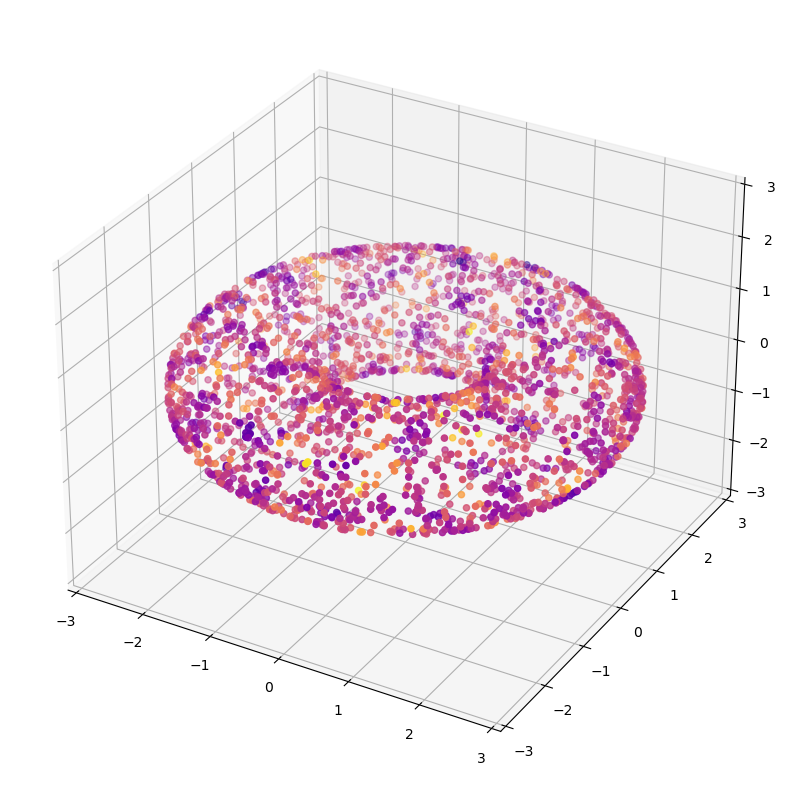

In [ ]:
plot_3d(X,P_local_entropy)

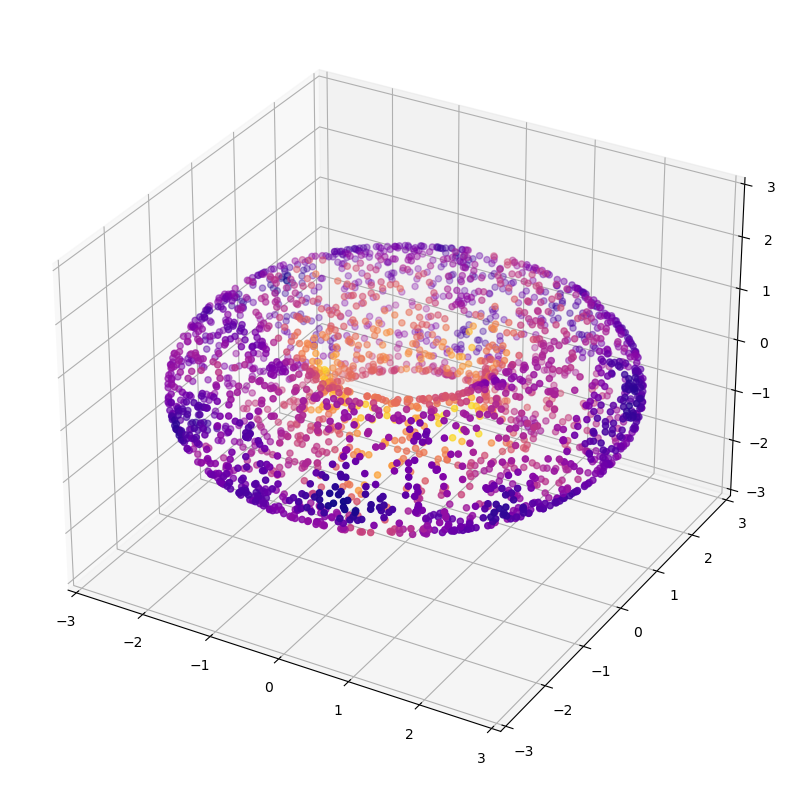

In [ ]:
plot_3d(X,P_entropy)

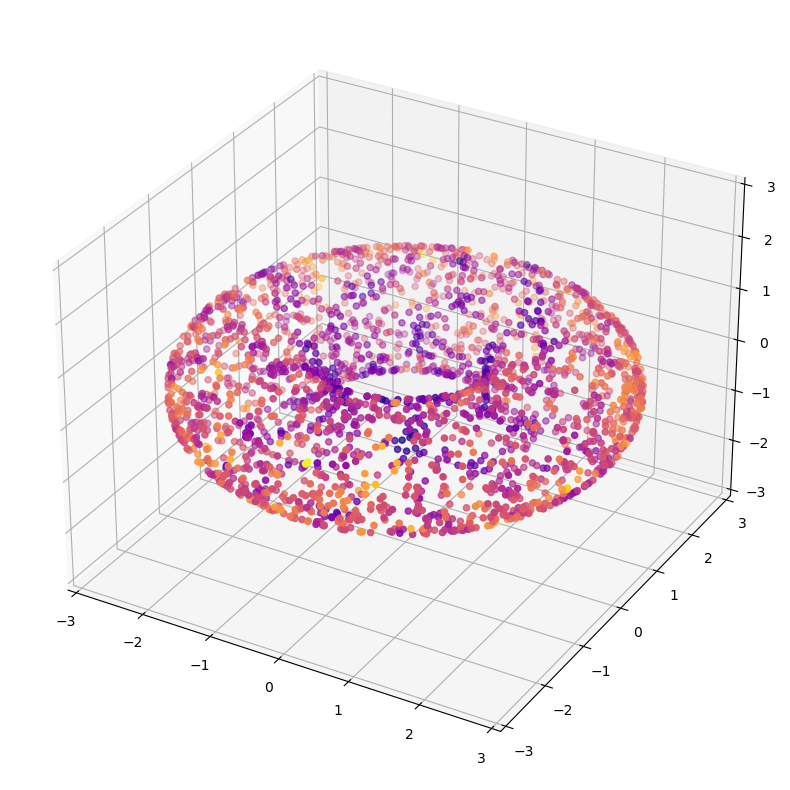

In [ ]:
plot_3d(X,P_local_entropy-P_entropy)

In [ ]:
X,ks_real = torus(2000,use_guide_points=True)

In [ ]:
def rate_of_change_of_entropy(X, k = 10):
    ts = list(range(1,32))
    entropies = np.empty((len(X),len(ts)))
    for idx, t in tqdm(enumerate(ts)):
        entropies[:,idx] = entropy_of_diffusion(X,t, k=k)
    return entropies

In [ ]:
es = rate_of_change_of_entropy(X)

0it [00:00, ?it/s]

In [ ]:
es

array([[4.07613972, 4.71251802, 5.06705814, ..., 6.6911089 , 6.70542128,
        6.7187397 ],
       [4.25568551, 5.00887328, 5.45887924, ..., 6.8445406 , 6.84859394,
        6.85235093],
       [4.14661593, 4.82497194, 5.20959129, ..., 6.75397896, 6.76406401,
        6.77344232],
       ...,
       [4.34268611, 5.04025557, 5.46457125, ..., 6.83200893, 6.83686588,
        6.84137463],
       [3.9943758 , 4.76268969, 5.20245573, ..., 6.7516116 , 6.76173583,
        6.77116387],
       [3.89847292, 4.55304055, 4.94290205, ..., 6.6851619 , 6.69996682,
        6.71374143]])

<matplotlib.legend.Legend>

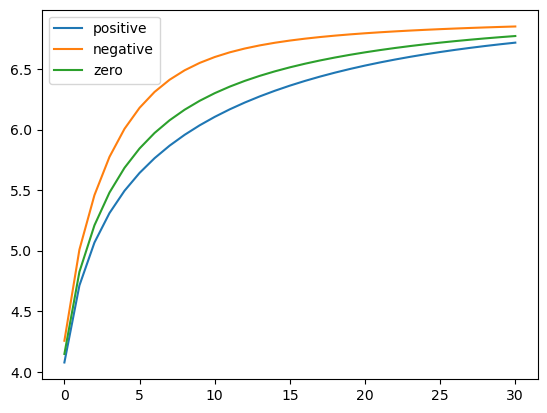

In [ ]:
plt.plot(es[0],label='positive')
plt.plot(es[1], label='negative')
plt.plot(es[2],label = 'zero')
plt.legend()

It's not clear that the rate of increase of the entropies is different. They do start out a little differently...
No, they all start out flat!

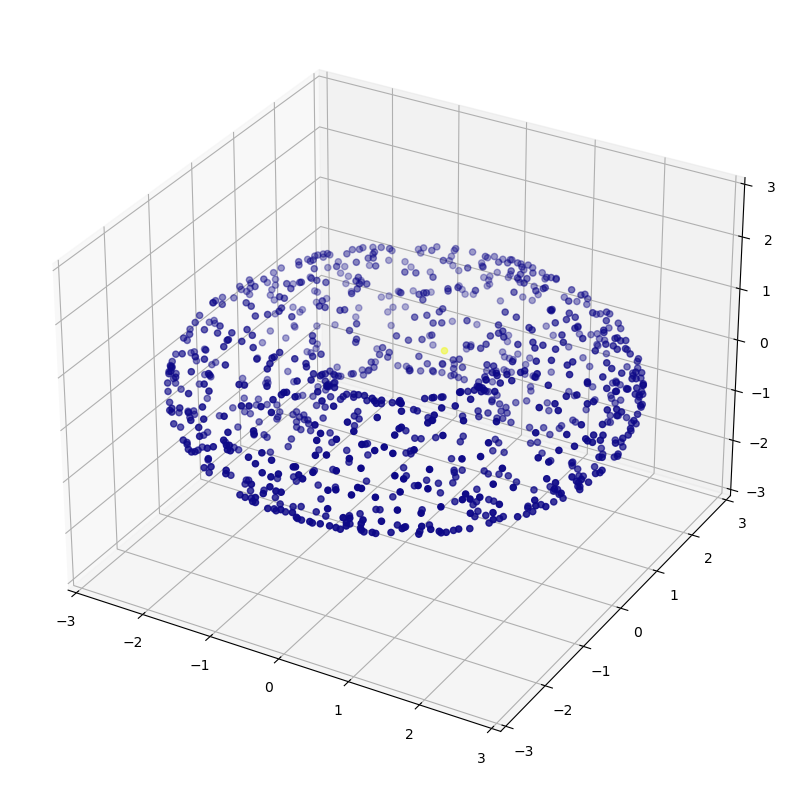

In [ ]:
sig = np.zeros(len(X))
sig[1] = 1
plot_3d(X,sig)